# 신용카드 번호 인식하기
- 목표 : OpenCV를 활용한 TEXT 영역 검출
- 유니크한 신용카드 숫자 모듈을 통한 인식
- 참고 싸이트 : https://blog.naver.com/tommybee/221837611962
- 여권 인식 : https://www.pyimagesearch.com/2015/11/30/detecting-machine-readable-zones-in-passport-images/
- 여권 인식 : https://www.pyimagesearch.com/2015/11/30/detecting-machine-readable-zones-in-passport-images/

In [126]:
# pip install --upgrade imutils
from imutils import contours
import numpy as np
import argparse
import imutils
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

```
# construct the argument parser and parse the arguments
# argparse란? https://blog.naver.com/qbxlvnf11/221801181428
ap = argparse.ArgumentParser()
ap.add_argument("-i", "--image", required=True, help="path to input image")
ap.add_argument("-r", "--reference", required=True, help="path to reference OCR-A image")
args = vars(ap.parse_args())
```

```
--image : OCR'd가 될 이미지의 경로.
--reference : 참조 OCR-A 영상의 경로.
```

In [127]:
# define a dictionary that maps the first digit of a credit cart
# number to the credit card type
FIRST_NUMBER = {
    "3": "American Express",
    "4": "Visa",
    "5": "MasterCard",
    "6": "Discover Card"
}

In [128]:
# load the reference OCR-A image from disk, convert it to grayscale.
# and threshold it, such that the digits appear as *white* on a *black* background
# and invert it, such that the digits appear as *white* on a *black*
# ref = cv2.imread(args["reference"])
#ref = cv2.imread('./reference/OCR-A_char_digits.png', 0)
ref = cv2.imread('./reference/OCR-A_char_digits.jpg', 0)
#ref = cv2.cvtColor(ref, cv2.COLOR_BGR2GRAY)
#ref = cv2.threshold(ref, 10, 255, cv2.THRESH_BINARY_INV)[1]
#cv2.imshow('ref', ref)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

In [129]:
# 윤곽선 검출
refCnts = cv2.findContours(ref.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
refCnts = imutils.grab_contours(refCnts)
refCnts = contours.sort_contours(refCnts, method='left-to-right')[0]
digits = {}

In [130]:
# loop over the OCR-A reference contours
# 각 검출 객체마다 순환하면서 좌표정보를 취득하고 ROI를 57x88로 고정
# 해당 roi를 digits dictionary에 저장
for (i, c) in enumerate(refCnts):
    # compute the bounding box for the digit, extract it, and resize
    # it to a fixed size
    (x, y, w, h) = cv2.boundingRect(c)
    roi = ref[y:y + h, x:x + w]
    roi = cv2.resize(roi, (57, 88))
    
    # update the digits dictionary, mapping the digit name to the ROI
    digits[i] = roi

## image 폴더 내의 신용카드 이미지 데이터에서 신용카드 번호 추출

In [131]:
# 두개의 구조화 커널을 초기화
# initalize a rectangular (wider than it is tall) and square
rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 3))  # 직사각형 커널
sqKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))   # 정사각형 커널

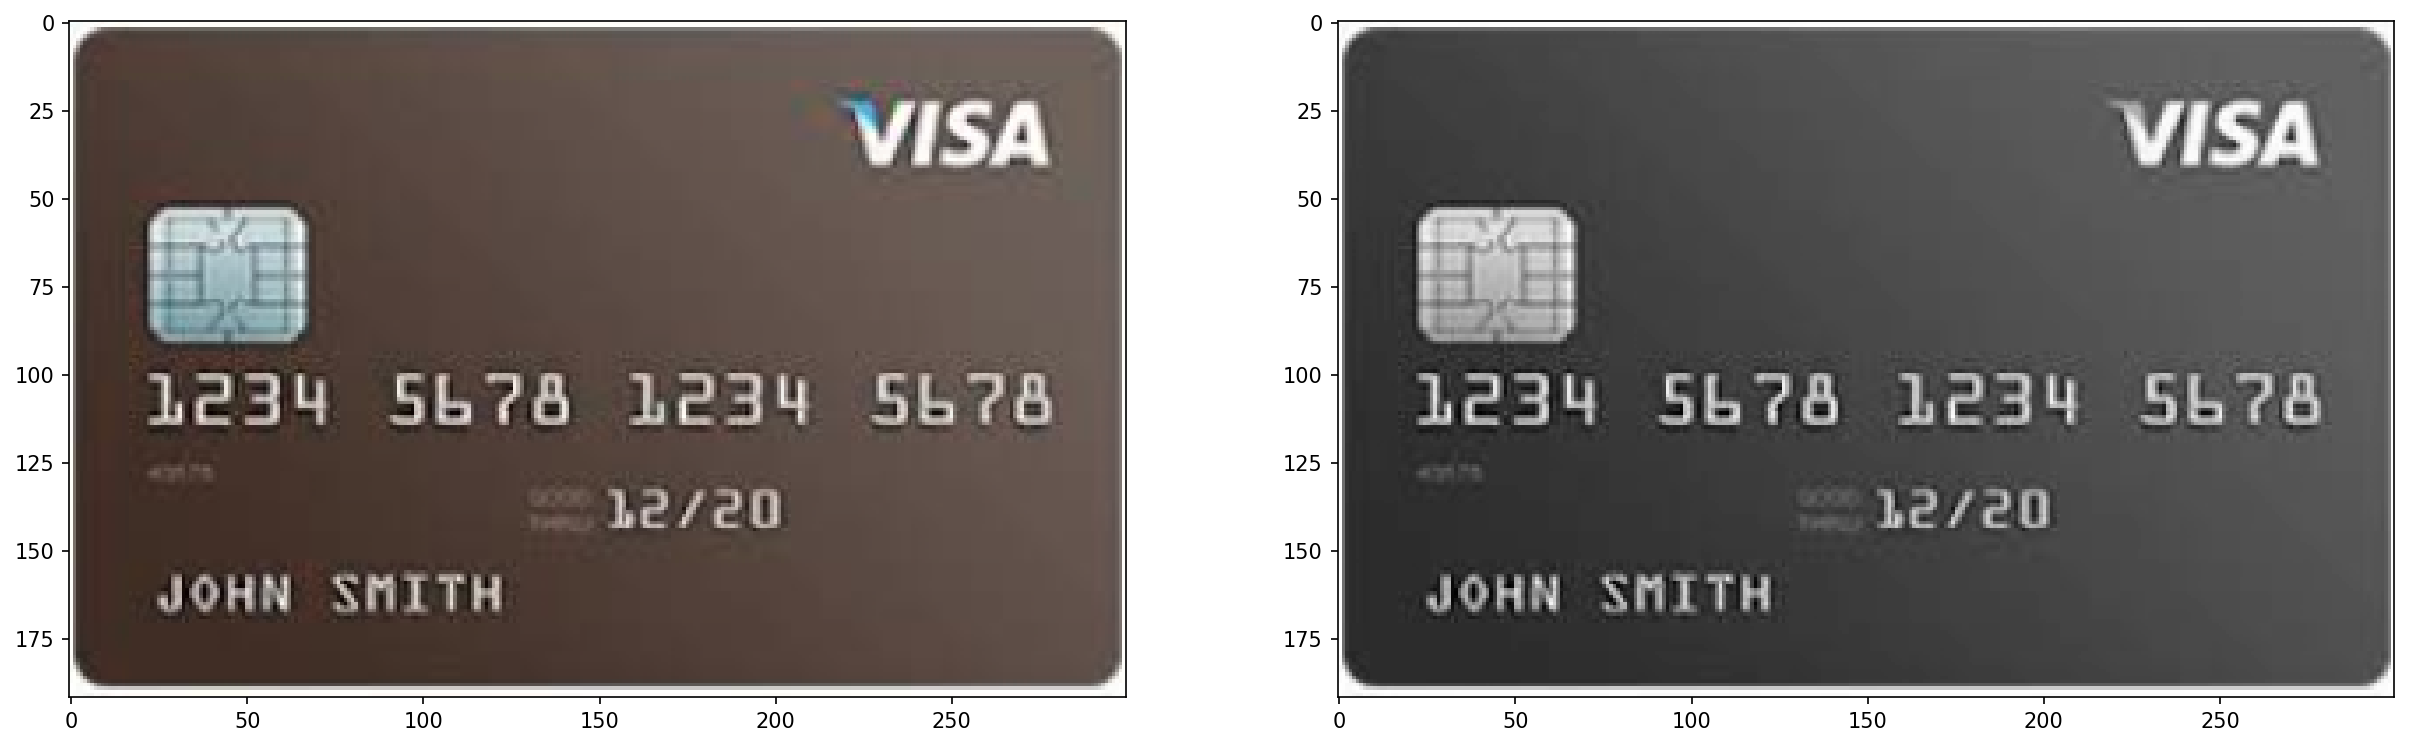

In [132]:
# 커널로 convolution하면서 blur, sharpen(갈림), edge detection 작업 진행
# load input image, resize it, and convert it to grayscale
image = cv2.imread('./image/creditcard_visa.jpg')
image = imutils.resize(image, width=300)
image_copy = image.copy()
# image2 = cv2.resize(image, (300, 192))
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Plot
plt.figure(figsize=(20, 10), dpi=150)
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray', vmin=0, vmax=255)

plt.subplot(1, 2, 2)
plt.imshow(gray, cmap='gray', vmin=0, vmax=255)

plt.show()

In [133]:
# apply a tophat morphological operator to find light
# regions against a dark background (i.e the credit card numbers)
tophat = cv2.morphologyEx(gray, cv2.MORPH_TOPHAT, rectKernel)
#cv2.imshow('tophat', tophat)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

- tophat 이미지에서 x-방향의 그라디언트 계산

In [134]:
# compute the Scharr gradient of the tophat image, then scale
# the rest back into the range [0, 255]
# 소벨을 통해 엣지 검출 (하기 이미지 참조)
gradX = cv2.Sobel(tophat, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=-1)
gradX = np.absolute(gradX)
gradY = cv2.Sobel(tophat, ddepth=cv2.CV_32F, dx=0, dy=1, ksize=-1)
gradY = np.absolute(gradY)
#cv2.imshow('image_org', image)
#cv2.imshow('gradX', gradX)
#cv2.imshow('gradY', gradY)

(minVal, maxVal) = (np.min(gradX), np.max(gradX))
gradX = (255 * ((gradX - minVal) / (maxVal - minVal)))
gradX = gradX.astype('uint8')
#cv2.imshow('gradX_x', gradX)

(minVal, maxVal) = (np.min(gradY), np.max(gradY))
gradY = (255 * ((gradY - minVal) / (maxVal - minVal)))
gradY = gradY.astype('uint8')
#cv2.imshow('gradY_y', gradY)

#cv2.waitKey(0)
#cv2.destroyAllWindows()

### Sobel
![sobel](https://github.com/tenjumh/GraduateSchool/blob/master/Computer%20Vision/Image%20Edge_operators/image/Sobel.PNG?raw=True)


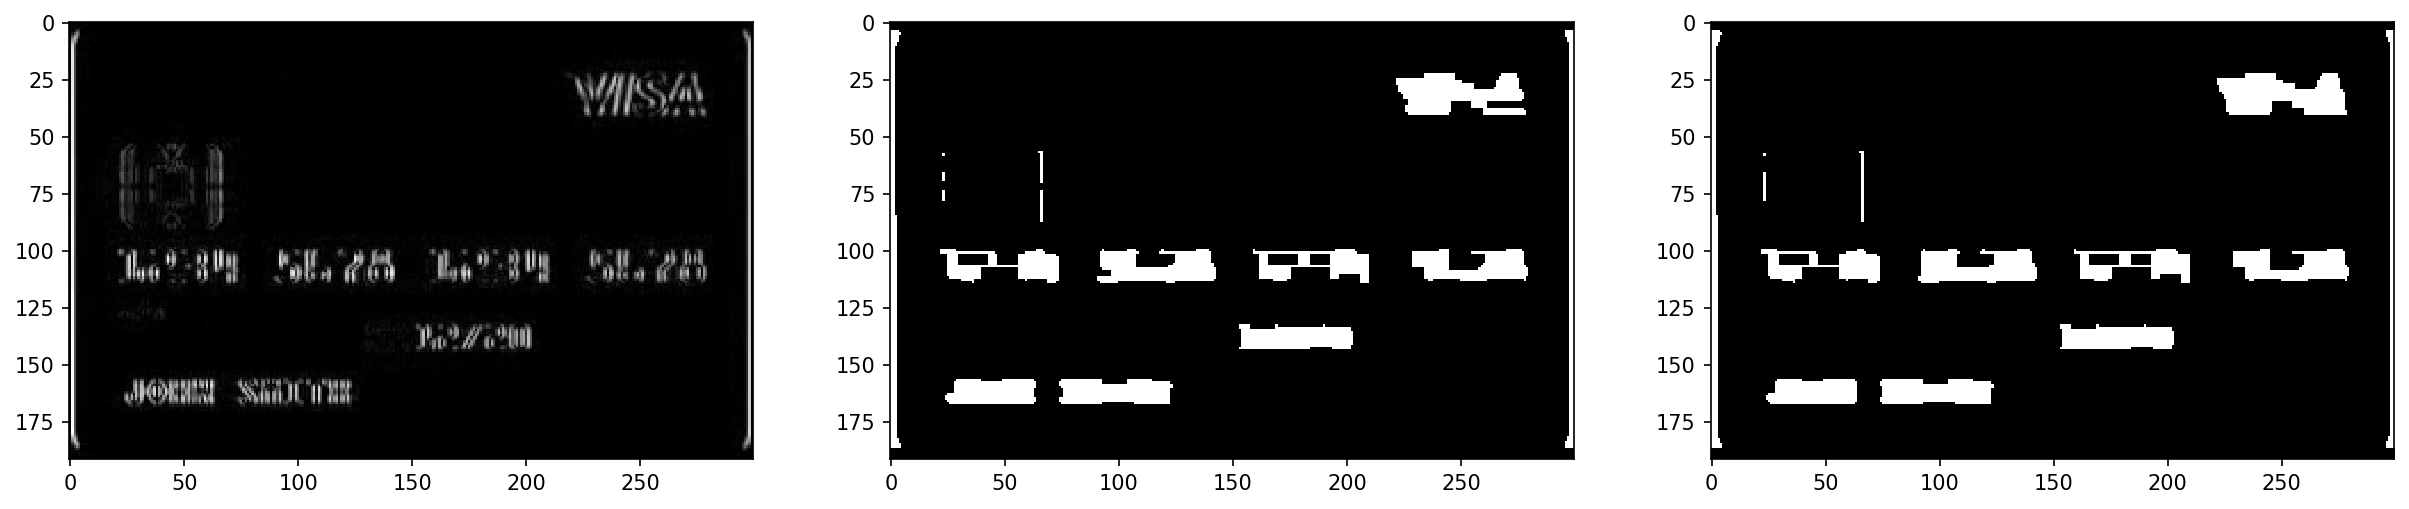

In [135]:
# apply a closing operation using the rectangular kernel to help
# close gaps in between credit card number digits, then apply
# Otsu's thresholding method to binarize the image
gradX_ = cv2.morphologyEx(gradX, cv2.MORPH_CLOSE, rectKernel)
thresh = cv2.threshold(gradX_, 0 , 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

# apply a second closing operation to the binary image, again
# to help close gaps between credit card number regions
thresh1 = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, sqKernel)
# Plot
plt.figure(figsize=(20, 10), dpi=150)
plt.subplot(1, 3, 1)
plt.imshow(gradX, cmap='gray', vmin=0, vmax=255)

plt.subplot(1, 3, 2)
plt.imshow(thresh, cmap='gray', vmin=0, vmax=255)

plt.subplot(1, 3, 3)
plt.imshow(thresh1, cmap='gray', vmin=0, vmax=255)

plt.show()

In [136]:
# find contours in the thresholded image, then initialize the list of diti locations
cnts = cv2.findContours(thresh1.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
locs = []

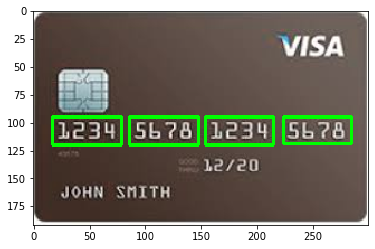

In [137]:
# loop over the contours
for (i, c) in enumerate(cnts):
    # compute the bounding box of the contour, then use the bounding box coordinates to derive the aspect ratio
    (x, y, w, h) = cv2.boundingRect(c)
    ar = w / float(h)
    
    # since credit cards used a fixed size fonts with 4 groups of 4 digits,
    # we can prune potential contours based on the aspect ratio
    if ar > 2.5 and ar < 4.0:
        # contours can further be pruned on minimum/maximm width and height
        if (w > 40 and w < 55) and (h > 10 and h < 20):
            # append the bounding box region of the digits group to our locations list
            locs.append((x, y ,w, h))
            img_rec = cv2.rectangle(image_copy, (x-5, y-5), (x+w+5, y+h+5), (0, 255, 0), 2)
            
plt.imshow(img_rec, cmap='gray', vmin=0, vmax=255)
#cv2.imshow("rectangle", img_rec)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

In [139]:
# sort the digit locations from left-to-right, then initialize the list of classified digits
print('Sorting 전:', locs)
locs1 = sorted(locs, key=lambda x:x[0])
output = []
print('Sorting 후:',locs1)

Sorting 전: [(229, 100, 51, 14), (159, 100, 51, 15), (91, 100, 52, 15), (22, 100, 52, 15)]
Sorting 후: [(22, 100, 52, 15), (91, 100, 52, 15), (159, 100, 51, 15), (229, 100, 51, 14)]


In [ ]:
# loop over the 4 groupings of 4 digits
for (i, (gX, gY, gW, gH)) in enumerate(locs):
    # inintialize the list of group digits
    groupOutput = []
    
    # extract the group ROI of 4 digits from the grayscales image,
    # then apply thresholding to segments the digits from the background of the credit card
    group = gray[gX: gY+gH: gX, gX+gW]
    group = cv2.threshold(group, 0 , 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    
    digitCnts = cv2.findContours(group.copy(), cv2.RETR_EXTERNAL,
                                cv2.CHAIN_APPROX_SIMPLE)
    digitCnts = imutils.grab_contours(digitCnts)
    digitCnts = 